In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import PIL.Image as Image
import torchvision.models as models
import zipfile
import time
import copy

In [2]:
# with zipfile.ZipFile('chest_xray.zip','r') as zip_ref:
#     zip_ref.extractall('./data/')
    
data_path = './data/chest_xray/'

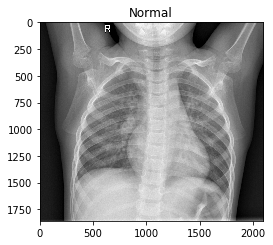

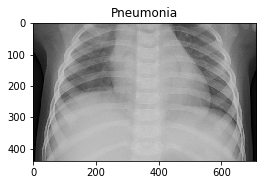

In [3]:
# The function to show an image
def imshow(img, title=None):
    plt.figure(figsize = (4, 4))
    plt.imshow(img)
    plt.title(title)
    plt.pause(0.001)

# Show an image of normal chest.
image_nor = Image.open(data_path + 'train/NORMAL/IM-0115-0001.jpeg')
imshow(image_nor, title = 'Normal')

# Show an image of a pneumonia.
image_pneu = Image.open(data_path + 'train/PNEUMONIA/person1_bacteria_1.jpeg')
imshow(image_pneu, title = 'Pneumonia')

In [4]:
#Prepare for dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
batch_size = 4

transform = transforms.Compose([transforms.Resize(256), transforms.RandomResizedCrop(227), transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])

trainset = torchvision.datasets.ImageFolder(root=data_path+'train', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size, shuffle = True)

valset = torchvision.datasets.ImageFolder(root=data_path+'val', transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size = 1, shuffle = True)

testset = torchvision.datasets.ImageFolder(root=data_path+'test', transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True)

classes = trainset.classes
print(classes)

['NORMAL', 'PNEUMONIA']


In [5]:
dataloaders = {'train': trainloader, 'val': valloader}
dataset_sizes = {'train': len(trainset), 'val': len(valset)}

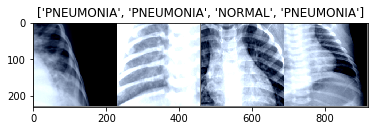

In [6]:
# The function to show a tensor image.    
def imshow_tensor(img, title = None):
    # Set a three channels image.
    img = img.numpy().transpose((1, 2, 0))   
    
    # Unnormalize.
    img = img / 2 + 0.5
    
    # Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
    img = np.clip(img, 0, 1)
    
    # Print label.
    plt.title(title)
    
    plt.imshow(img)
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, label = next(dataiter)
# Show images.
imshow_tensor(torchvision.utils.make_grid(images), title = [classes[label[j]] for j in range(batch_size)])


In [7]:
# trainiter = iter(trainloader)
# features, labels = next(trainiter)
# print(features.shape)
# print(labels.shape)

In [8]:
#choose a device
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

cuda:0
GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [9]:

avg_losses = []

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                avg_losses.append(epoch_loss)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=2, padding=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(32))
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64))
        
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(128))
        
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(256))
        
        self.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256*7*7, 100),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(100, 2),
            nn.Softmax(dim=1))

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                imshow_tensor(inputs.cpu().data[j], title=[classes[labels[j]]])
                print('predicted: {}'.format(classes[preds[j]]))

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [13]:
model_ft = Net()   # Create the network instance.

model_ft.to(device)  # Move the network parameters to the specified device.

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [14]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=11)

Epoch 0/10
----------
train Loss: 0.5023 Acc: 0.7993
val Loss: 0.7116 Acc: 0.6250

Epoch 1/10
----------
train Loss: 0.4688 Acc: 0.8380
val Loss: 0.8124 Acc: 0.5000

Epoch 2/10
----------
train Loss: 0.4671 Acc: 0.8390
val Loss: 0.6670 Acc: 0.6250

Epoch 3/10
----------
train Loss: 0.4574 Acc: 0.8503
val Loss: 0.8122 Acc: 0.5000

Epoch 4/10
----------
train Loss: 0.4463 Acc: 0.8623
val Loss: 0.7830 Acc: 0.5000

Epoch 5/10
----------
train Loss: 0.4557 Acc: 0.8524
val Loss: 0.6618 Acc: 0.5625

Epoch 6/10
----------
train Loss: 0.4497 Acc: 0.8587
val Loss: 0.7660 Acc: 0.5625

Epoch 7/10
----------
train Loss: 0.4360 Acc: 0.8721
val Loss: 0.7005 Acc: 0.5625

Epoch 8/10
----------
train Loss: 0.4324 Acc: 0.8752
val Loss: 0.8044 Acc: 0.5000

Epoch 9/10
----------
train Loss: 0.4309 Acc: 0.8775
val Loss: 0.7131 Acc: 0.6250

Epoch 10/10
----------
train Loss: 0.4322 Acc: 0.8763
val Loss: 0.7456 Acc: 0.5000

Training complete in 45m 51s
Best val Acc: 0.625000


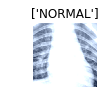

predicted: PNEUMONIA


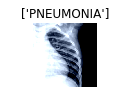

predicted: PNEUMONIA


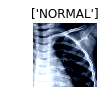

predicted: PNEUMONIA


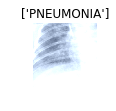

predicted: PNEUMONIA


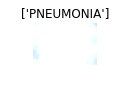

predicted: PNEUMONIA


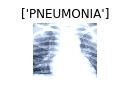

predicted: PNEUMONIA


In [15]:
visualize_model(model_ft)

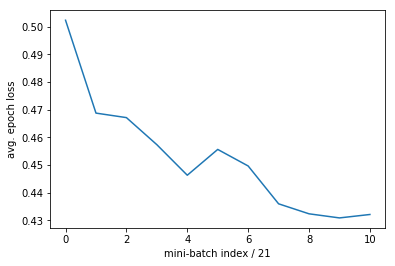

In [16]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(21))
plt.ylabel('avg. epoch loss')
plt.show()

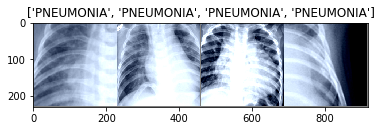

Predicted:  PNEUMONIA PNEUMONIA PNEUMONIA PNEUMONIA


In [17]:
# Check several images.
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow_tensor(torchvision.utils.make_grid(images), title = [classes[labels[j]] for j in range(batch_size)])
outputs = model_ft(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

In [18]:
# Get test accuracy.
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 72 %


In [19]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_ft(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(batch_size):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of NORMAL : 34 %
Accuracy of PNEUMONIA : 97 %
